# Background Obective

Home Credit is currently using various statistical methods and Machine Learning to make credit score predictions. Now, we ask you to unlock the maximum potential of our data. In this way, we can ensure that customers who are able to make repayment are not rejected when applying for a loan, and loans can be given with a principal, maturity, and payment calendar that will motivate customers to be successful. Evaluation will be carried out by checking how deep your understanding of the analysis you are working on is. For the record, you need to use at least 2 Machine Learning models, one of which is Logistic Regression.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# metrics used in classification
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

# set chart theme
sns.set_theme(style="whitegrid", palette="pastel")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [3]:
df_credit = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/df_final.csv')
df_credit = df_credit.drop(df_credit.columns[0], axis=1)
app_credit = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')

# Data Preprocessing

In this section, we would be wrangling the data. We would have to change the datatypes and doing feature engineering to make ML model perform better.

But before merging the dataset into one dataset, we have to take a look at those datas one by one.

In [4]:
app_credit.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_credit.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [6]:
# general information
app_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
# checking missing values
pd.DataFrame(app_credit.isna().sum() / len(app_credit) * 100)

,0
SK_ID_CURR,0.000000
TARGET,0.000000
NAME_CONTRACT_TYPE,0.000000
CODE_GENDER,0.000000
FLAG_OWN_CAR,0.000000
...,...
AMT_REQ_CREDIT_BUREAU_DAY,13.501631
AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
AMT_REQ_CREDIT_BUREAU_MON,13.501631
AMT_REQ_CREDIT_BUREAU_QRT,13.501631


In [8]:
# checking duplicates values
app_credit.duplicated().sum()

0

**Conclusion:**
- The data has **307510** rows and 122 columns.
- There is no duplicates values.
- There are some columns with missing values that need to be handled.

## Deleting Columns with Missing Values

In [9]:
# getting columns with missing values
def get_missing(data, num):
  '''
  get the columns with the largest missing values
  '''
  percentage_mv = data.isna().sum() / len(data) * 100
  missing_values = []
  for i in zip(percentage_mv.index,percentage_mv.values):
      if i[1] > num: # getting column with more than 10% missing values
          missing_values.append(i[0])
  return missing_values

In [10]:
# column with missing columns
col_missing_values = get_missing(app_credit, 10)
len(col_missing_values)

57

In [11]:
# drop the columns with missing values
app_credit = app_credit.drop(col_missing_values, axis=1)
app_credit.shape

(307511, 65)

In [12]:
# checking missing values
app_credit.isnull().sum().sort_values()

SK_ID_CURR                        0
HOUR_APPR_PROCESS_START           0
FLAG_DOCUMENT_20                  0
REG_REGION_NOT_WORK_REGION        0
LIVE_REGION_NOT_WORK_REGION       0
                               ... 
OBS_30_CNT_SOCIAL_CIRCLE       1021
DEF_30_CNT_SOCIAL_CIRCLE       1021
OBS_60_CNT_SOCIAL_CIRCLE       1021
DEF_60_CNT_SOCIAL_CIRCLE       1021
NAME_TYPE_SUITE                1292
Length: 65, dtype: int64

## Handling Missing Values

Because there are more tahn a thousand rows that has missing values. So, we need to impute it with some values (categorical or numerical).

In [13]:
# get numeric columns
num_cols = [i for i in app_credit.columns if app_credit[i].isnull().any() and app_credit[i].dtypes != 'object']

# get categorical columns
obj_cols = [i for i in app_credit.columns if app_credit[i].isnull().any() and app_credit[i].dtypes == 'object']

In [14]:
print(num_cols, obj_cols)

['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE'] ['NAME_TYPE_SUITE']


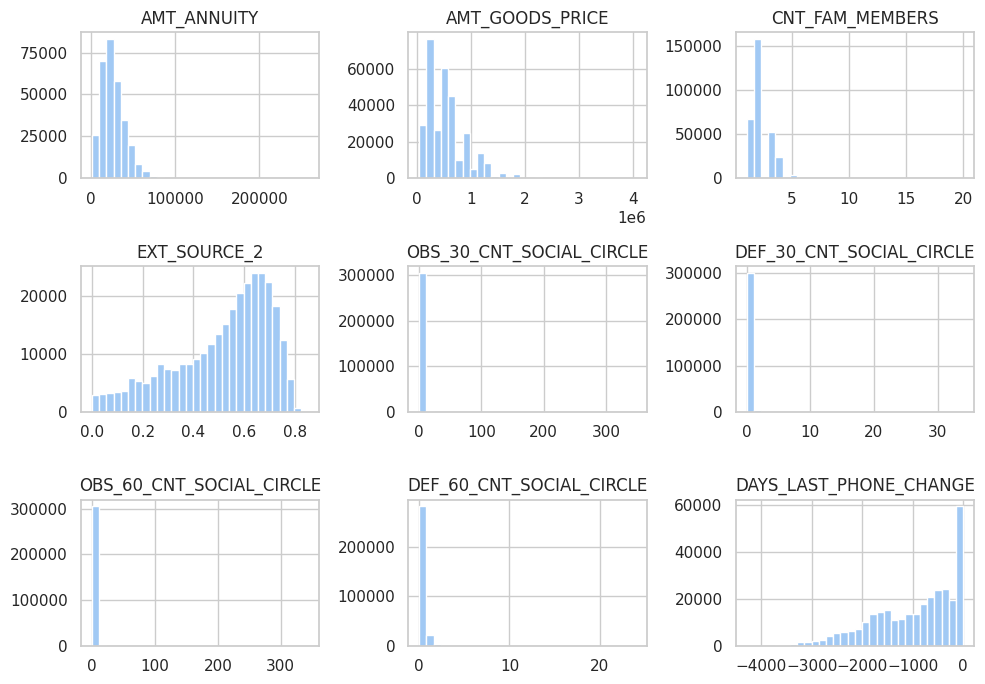

In [15]:
# columns (numerical) distribution with missing values
fig, axs = plt.subplots(3,3,figsize=(10,7))

for i, col in enumerate(num_cols):
    axs[int(i // 3), i % 3].hist(app_credit[col], bins=30)  # Access axes using indexing
    axs[int(i // 3), i % 3].set_title(col)  # Set title

# Adjust layout (optional)
plt.tight_layout()
plt.show()

**Conclusion:**

The distribution of columns with missing values seems skewed. There must be outliers there. To overcome that, we impute the value with median value.

In [16]:
# impute the missing values with median value
for cols in app_credit[num_cols]:
  app_credit[cols] = app_credit[cols].fillna(app_credit[cols].median())

In [17]:
# columns (categorical) distribution with missing values
type_suite = app_credit[obj_cols].value_counts()
type_suite

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
dtype: int64

In [18]:
# impute the missing values in categorical with mode
app_credit[obj_cols] = app_credit[obj_cols].fillna(app_credit[obj_cols].mode().loc[0][0])

In [19]:
# check again if there is a missing value or not
app_credit[obj_cols].isna().sum()

NAME_TYPE_SUITE    0
dtype: int64

## Deleting Unnecessary Columns (in my opinion)

Because we just analyze several columns. So, we delete several columns that for me has no meaning in analyzing user's behaviour and keeping several columns for building a model.

In [20]:
# seeing columns
app_credit.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCI

In [21]:
# unnecessary columns
# deleting flag document column
Flag = [col for col in app_credit.columns if "FLAG_DOCUMENT" in col]
app_credit = app_credit.drop(Flag, axis=1)
app_credit.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0


# Learning The Core Parameters

In this section we will be learning about the core parameters of this dataset. Core parameter is a parameter that gives us important information about the data and helps us identify the problem.

What would we do:
- Checking outliers.
- Deleting outliers.
- Checking unique values.
- Replacing values.

## Categorical Values

In [22]:
[col for col in app_credit.columns if app_credit[col].dtype in ['object'] and app_credit[col].nunique()>2]

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

We only see the unique values in categorical columns with more than 2 values. If there is a unique value. We can change it to unknown or mode.

### Code Gender

After checking the columns one by one, we only change the code gender values. Because it is only 2 genders not 3.

In [23]:
app_credit['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [24]:
app_credit.pivot_table(index='CODE_GENDER', values='SK_ID_CURR', aggfunc='count')

,SK_ID_CURR
CODE_GENDER,
F,202448
M,105059
XNA,4


As we see, there is a value called XNA. Maybe it means someone who doesn't want other people know about their gender. Because it is only 4 XNA. So, we will replace it with mode values.

In [25]:
app_credit['CODE_GENDER'].mode()[0]

'F'

In [26]:
app_credit['CODE_GENDER'] = app_credit['CODE_GENDER'].replace('XNA', app_credit['CODE_GENDER'].mode()[0])

In [27]:
app_credit['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

## Numerical Values

In here, there are some categories in numerical columns we need to check:
* Negative values that is not supposed to be. Like days columns.
* The count columns. Like family members and count of kids.
* Checking the anomali values that so extreme.

In [28]:
[col for col in app_credit.columns if app_credit[col].dtype not in ['object'] and app_credit[col].nunique()>2 and app_credit[col].nunique()<=20]

['CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

### Checking Negative Values

In [29]:
neg_col = [col for col in app_credit.columns if app_credit[col].dtype not in ['object'] and app_credit[col].min()<0]
neg_col

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

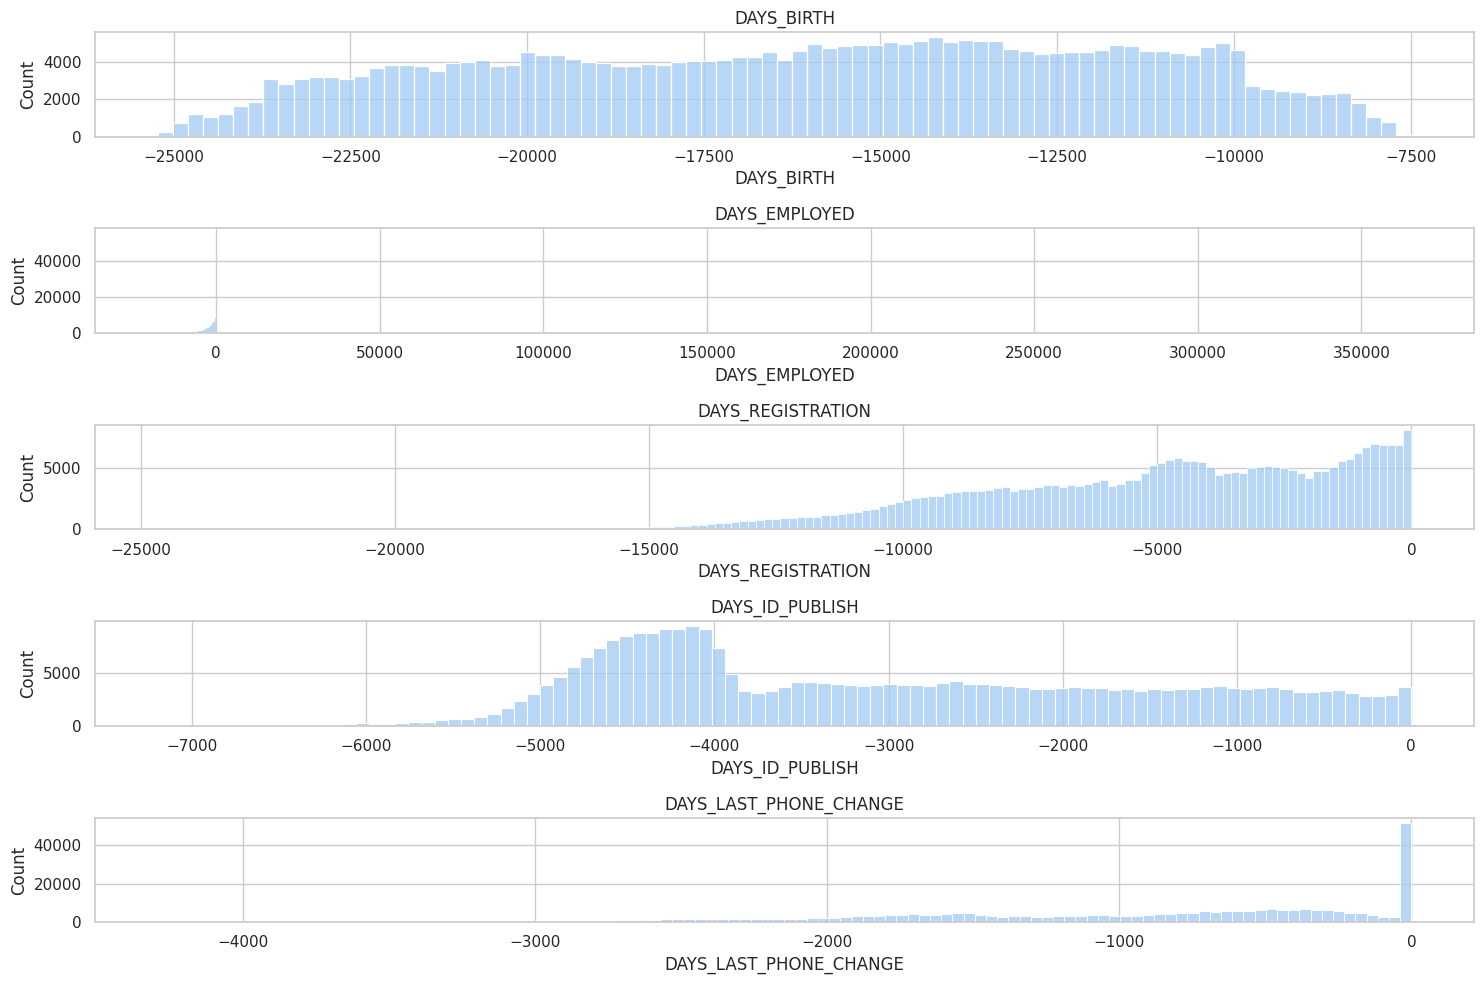

In [30]:
# histotgram chart
fig, axes = plt.subplots(nrows=5, ncols=len(neg_col)//5, figsize=(15, 10))
for i, col in enumerate(neg_col):
  sns.histplot(data=app_credit, x=col, ax=axes[i])
  axes[i].set_title(col)
plt.tight_layout()
plt.show()

The values is pretty skewed and also it is really weird when there is negative values in days columns. So we need to fix that with make it positive.

In [31]:
app_credit[neg_col] = np.abs(app_credit[neg_col] )

In [32]:
app_credit[neg_col].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,9461,637,3648.0,2120,1134.0
1,16765,1188,1186.0,291,828.0
2,19046,225,4260.0,2531,815.0
3,19005,3039,9833.0,2437,617.0
4,19932,3038,4311.0,3458,1106.0


### Checking Anomali Values

Some columns that need to check is:
* count children.
* count family members.

Normally there is no more than 5 children in a family and in one family, there is supposed to be at least 5 members.

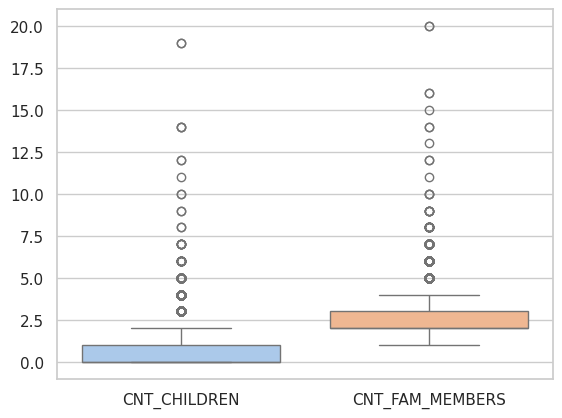

In [33]:
# using boxplot to check the anomali
sns.boxplot(app_credit[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']])
plt.show()

There is a lot of anomalis there. So special for this column. We will filter these columns based on upper limit.

In [34]:
# quartile values for cnt_children
q1_child = app_credit['CNT_CHILDREN'].quantile(0.25)
q3_child = app_credit['CNT_CHILDREN'].quantile(0.75)
iqr_child = q3_child - q1_child

upper_limit = q3_child+(1.5*iqr_child)
lower_limit = q1_child-(1.5*iqr_child)

2.5


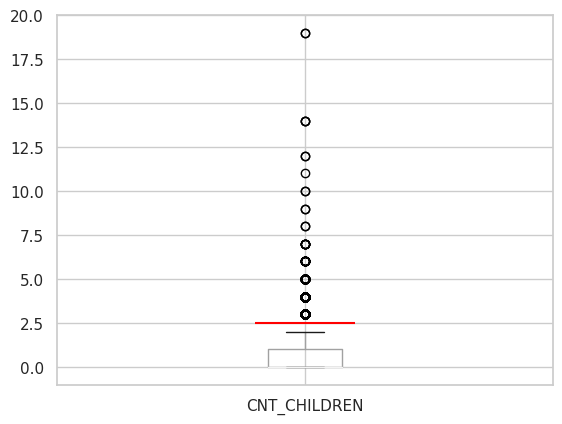

In [35]:
print(upper_limit)
plt.ylim(-1, 20)
app_credit.boxplot(column='CNT_CHILDREN')
plt.hlines(y=upper_limit, xmin=0.9,xmax=1.1, color='red')
plt.show();

In [36]:
# quartile values for cnt_fam_members
q1_fam = app_credit['CNT_FAM_MEMBERS'].quantile(0.25)
q3_fam = app_credit['CNT_FAM_MEMBERS'].quantile(0.75)
iqr_fam = q3_fam - q1_fam

upper_limit_fam = q3_fam+(1.5*iqr_fam)
lower_limit_fam = q1_fam-(1.5*iqr_fam)

4.5


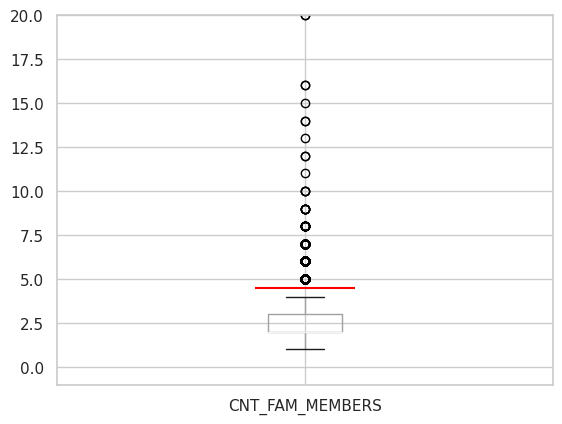

In [37]:
print(upper_limit_fam)
plt.ylim(-1, 20)
app_credit.boxplot(column='CNT_FAM_MEMBERS')
plt.hlines(y=upper_limit_fam, xmin=0.9,xmax=1.1, color='red')
plt.show();

Based on the upper limit, for count children we will take 0 to 3 and family members we will take from 1 to 5.

### Filter The Dataset

In [38]:
app_credit = app_credit.query('CNT_CHILDREN<=3 or CNT_FAM_MEMBERS<=5')

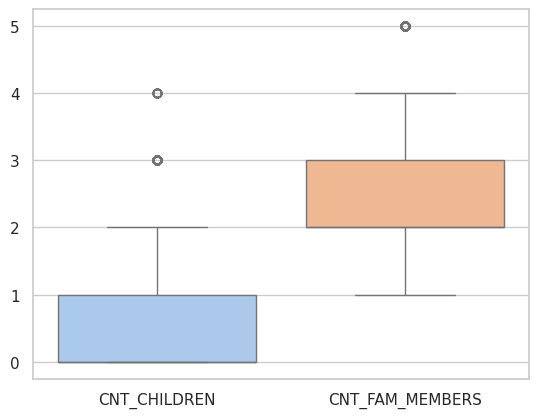

In [39]:
# check the anomali again
sns.boxplot(app_credit[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']])
plt.show()

# EDA (Exploratory Data Analysis)

In exploring the data, we would be asking various questions that need answers in order to uncover or understand the data.

**Several Questions:**
- Number of people who are struggling to make payments and those who are not.
- Average loan amount and repayment capacity based on family status.
- Amount of credit borrowed based on assets owned.
- Do certain types of jobs experience difficulty making payments? And how much credit do they borrow?
- Do certain types of organizations experience difficulty making payments? And how much do they borrow?

## Number of people who are struggling to make payments and those who are not

                         TARGET  PERCENTAGE
No Payment Difficulties  282227     0.91936
Payment Difficulties      24755     0.08064
------------------------------------------------------------


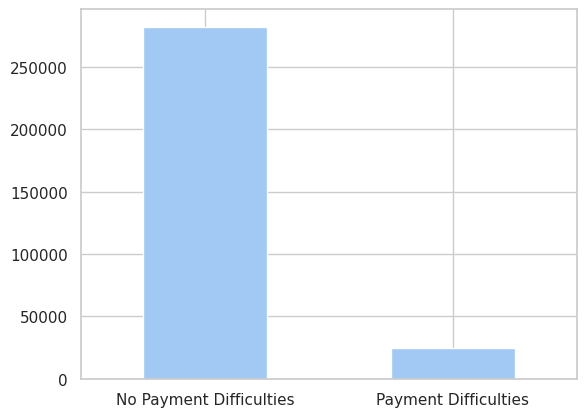

In [40]:
num_people = app_credit.groupby(['TARGET']).agg({'TARGET':'count'})
num_people.index = ['No Payment Difficulties', 'Payment Difficulties']
num_people['PERCENTAGE'] = num_people['TARGET'] / (num_people['TARGET'][0] + num_people['TARGET'][1])
print(num_people)
print('---'*20)

# plot distribution of target
num_people['TARGET'].plot(kind='bar')
plt.xticks(rotation=0)
plt.show();

**Conclusion:**
- There were many clients who had not payment difficulties than they who did.
- Around **90%** clients who had no problem in paying the loan. Beside, around **8%** who had a problem with paying the loan.
- The data is imbalanced. So we need to take care of this before training the model.

## Average loan amount and repayment capacity based on family status

In [41]:
# getting data about family
family_status = app_credit[['SK_ID_CURR', 'NAME_FAMILY_STATUS', 'TARGET', 'AMT_CREDIT']]
family_status

,SK_ID_CURR,NAME_FAMILY_STATUS,TARGET,AMT_CREDIT
0,100002,Single / not married,1,406597.5
1,100003,Married,0,1293502.5
2,100004,Single / not married,0,135000.0
3,100006,Civil marriage,0,312682.5
4,100007,Single / not married,0,513000.0
...,...,...,...,...
307506,456251,Separated,0,254700.0
307507,456252,Widow,0,269550.0
307508,456253,Separated,0,677664.0
307509,456254,Married,1,370107.0


In [42]:
# groupby family to see avg credit
groupby_family = family_status.groupby(['NAME_FAMILY_STATUS'], as_index=False)['AMT_CREDIT'].mean()
groupby_family['AMT_CREDIT'] = round(groupby_family['AMT_CREDIT'], 1)

     NAME_FAMILY_STATUS  AMT_CREDIT
0        Civil marriage    541572.0
1               Married    643064.7
2             Separated    552065.1
3  Single / not married    505366.4
4               Unknown    630000.0
5                 Widow    490715.1
------------------------------------------------------------


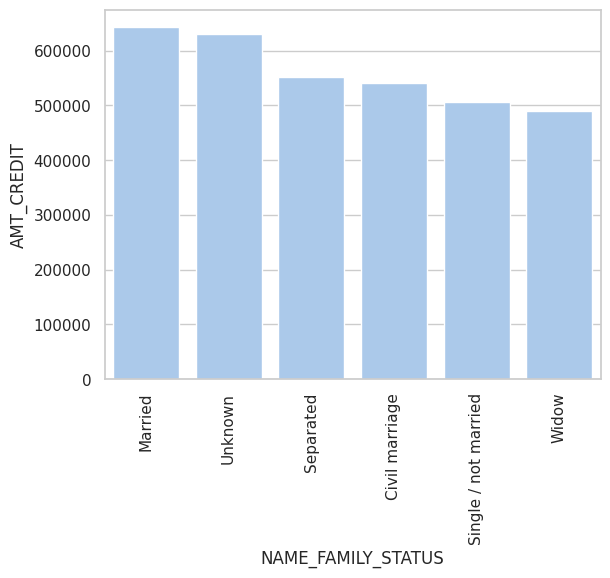

In [43]:
print(groupby_family)
print('---'*20)
# plot family status with avg credit
sns.barplot(groupby_family.sort_values(by='AMT_CREDIT',ascending=False), x='NAME_FAMILY_STATUS', y='AMT_CREDIT')
plt.xticks(rotation=90)
plt.show();

In [44]:
# groupby family to see the payments difficulities
groupby_family2 = family_status.groupby(['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
groupby_family2['TARGET'] = groupby_family2['TARGET'].map({0:'No Payment Difficulities',
                                                           1:'Payment Difficulities'})

      NAME_FAMILY_STATUS                    TARGET  SK_ID_CURR
0         Civil marriage  No Payment Difficulities       26784
1         Civil marriage     Payment Difficulities        2949
2                Married  No Payment Difficulities      181163
3                Married     Payment Difficulities       14794
4              Separated  No Payment Difficulities       18147
5              Separated     Payment Difficulities        1619
6   Single / not married  No Payment Difficulities       40984
7   Single / not married     Payment Difficulities        4456
8                Unknown  No Payment Difficulities           2
9                  Widow  No Payment Difficulities       15147
10                 Widow     Payment Difficulities         937
--------------------------------------------------------------------------------


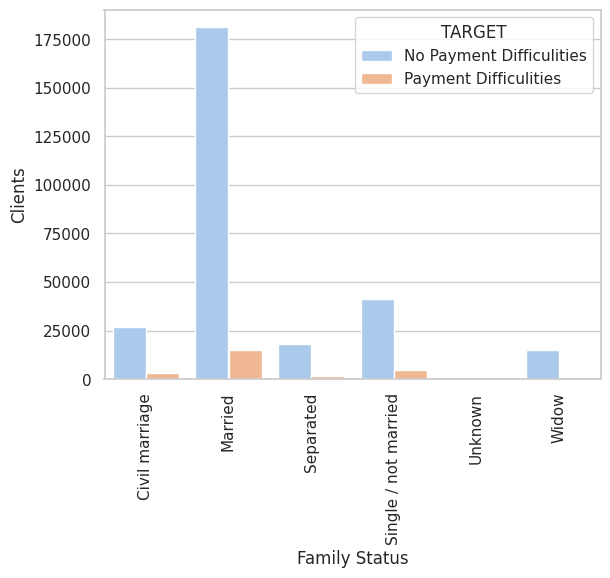

In [45]:
print(groupby_family2)
print("----"*20)
# plot to see how many family able to pay the loan
sns.barplot(x='NAME_FAMILY_STATUS', y='SK_ID_CURR',data=groupby_family2, hue='TARGET')
plt.xlabel('Family Status')
plt.ylabel('Clients')
plt.xticks(rotation=90)
plt.show();

**Conclusion:**
- The highest average for family status is married with **623512.6** and the last is widow with **480251.0**.
- Even the married status is the highest average in amount credit but they were able to pay the loan.
- Most of the family status had no difficulities payment.

## Amount of credit borrowed based on assets owned.

In [46]:
# taking the asset columns
col_asset = app_credit[['SK_ID_CURR','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_MOBIL', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'TARGET']]
col_asset.head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_MOBIL,NAME_HOUSING_TYPE,NAME_CONTRACT_TYPE,AMT_CREDIT,TARGET
0,100002,N,Y,1,1,House / apartment,Cash loans,406597.5,1
1,100003,N,N,1,1,House / apartment,Cash loans,1293502.5,0
2,100004,Y,Y,1,1,House / apartment,Revolving loans,135000.0,0
3,100006,N,Y,0,1,House / apartment,Cash loans,312682.5,0
4,100007,N,Y,0,1,House / apartment,Cash loans,513000.0,0


In [47]:
# flag own car
own_car = col_asset.groupby(['FLAG_OWN_CAR', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_car['TARGET'] = own_car['TARGET'].map({0:'No Payment Difficulities',
                                           1:'Payment Difficulities'})
# flag own realty
own_realty = col_asset.groupby(['FLAG_OWN_REALTY', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_realty['TARGET'] = own_realty['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
# flag phone
own_phone = col_asset.groupby(['FLAG_PHONE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_phone['TARGET'] = own_phone['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
own_phone['FLAG_PHONE'] = own_phone['FLAG_PHONE'].map({0:'N',
                                                       1:'Y'})
# flag mobil
own_mobil = col_asset.groupby(['FLAG_MOBIL', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
own_mobil['TARGET'] = own_mobil['TARGET'].map({0:'No Payment Difficulities',
                                              1:'Payment Difficulities'})
own_mobil['FLAG_MOBIL'] = own_mobil['FLAG_MOBIL'].map({0:'N',
                                                       1:'Y'})

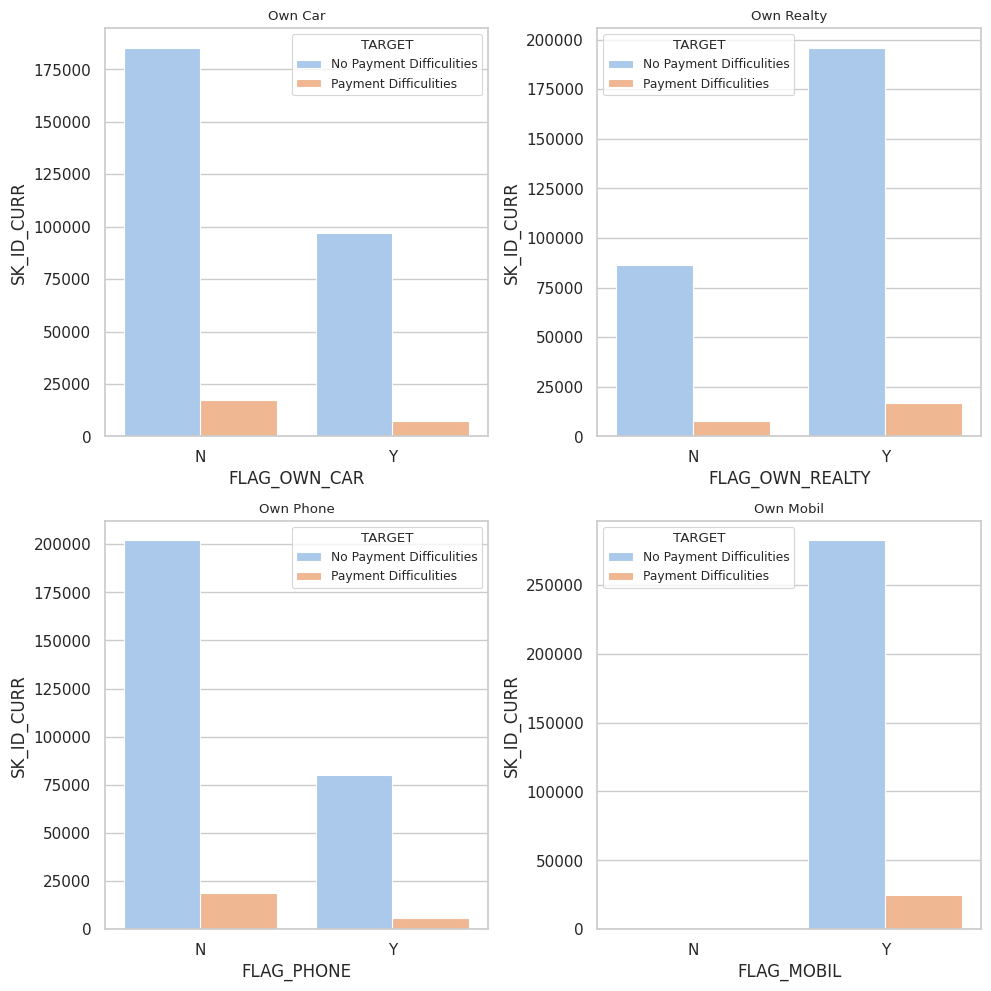

In [48]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title("Own Car")
sns.barplot(data=own_car, x='FLAG_OWN_CAR', y='SK_ID_CURR', hue='TARGET', ax=ax[0][0])

ax[0][1].set_title("Own Realty")
sns.barplot(data=own_realty, x='FLAG_OWN_REALTY', y='SK_ID_CURR', hue='TARGET', ax=ax[0][1])

ax[1][0].set_title("Own Phone")
sns.barplot(data=own_phone, x='FLAG_PHONE', y='SK_ID_CURR', hue='TARGET', ax=ax[1][0])

ax[1][1].set_title("Own Mobil")
sns.barplot(data=own_mobil, x='FLAG_MOBIL', y='SK_ID_CURR', hue='TARGET', ax=ax[1][1])

plt.tight_layout()

In [49]:
# name housing type
house_type = col_asset.groupby(['NAME_HOUSING_TYPE'], as_index=False)['AMT_CREDIT'].mean()
house_type.sort_values('AMT_CREDIT', ascending=False)

,NAME_HOUSING_TYPE,AMT_CREDIT
3,Office apartment,626233.643158
1,House / apartment,605154.875221
2,Municipal apartment,599529.182445
0,Co-op apartment,580248.414580
4,Rented apartment,525736.627385
5,With parents,506472.763200


**Conclusion:**
- Clients who had no car, had no payment difficulities more than they who had.
- Most of the clients who had no payment difficulities, had house or place to live.
- Clients who had phone, had no payment difficulities.
- There is no clients with no phone that had payment difficulities.
- Client who live in appartment, had the highest average of amount credit loan.

## Do certain types of jobs experience difficulty making payments? And how much credit do they borrow?

In [50]:
# take job type columns
type_jobs = app_credit[['SK_ID_CURR','NAME_INCOME_TYPE','TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']]
type_jobs.head()

,SK_ID_CURR,NAME_INCOME_TYPE,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
0,100002,Working,1,202500.0,406597.5
1,100003,State servant,0,270000.0,1293502.5
2,100004,Working,0,67500.0,135000.0
3,100006,Working,0,135000.0,312682.5
4,100007,Working,0,121500.0,513000.0


In [51]:
group_jobs = type_jobs.groupby(['NAME_INCOME_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
group_jobs['TARGET'] = group_jobs['TARGET'].map({0:'No Payment Difficulities',
                                                 1:'Payment Difficulities'})
group_jobs

,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulities,10
1,Commercial associate,No Payment Difficulities,66173
2,Commercial associate,Payment Difficulities,5347
3,Maternity leave,No Payment Difficulities,3
4,Maternity leave,Payment Difficulities,2
5,Pensioner,No Payment Difficulities,52365
6,Pensioner,Payment Difficulities,2980
7,State servant,No Payment Difficulities,20409
8,State servant,Payment Difficulities,1245
9,Student,No Payment Difficulities,18


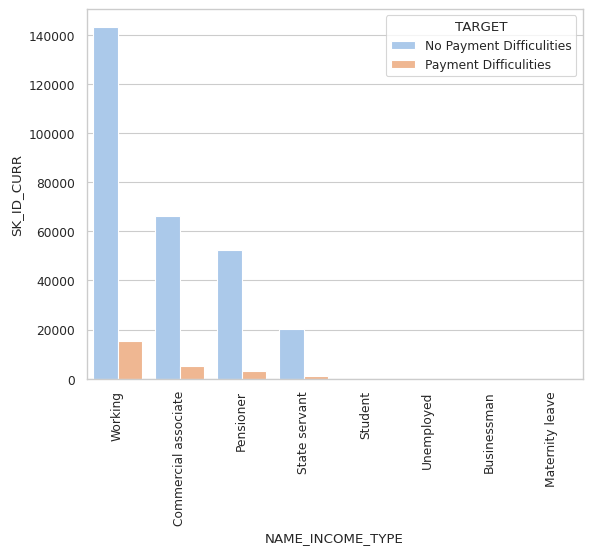

In [52]:
# making plot
sns.barplot(data=group_jobs.sort_values('SK_ID_CURR', ascending=False), x='NAME_INCOME_TYPE', y='SK_ID_CURR', hue='TARGET')
plt.xticks(rotation=90)
plt.show()

In [53]:
# based on how many credit theay are loan
jobs_loan = type_jobs.groupby(['NAME_INCOME_TYPE'], as_index=False)['AMT_CREDIT'].mean()
jobs_loan['AMT_CREDIT'] = round(jobs_loan['AMT_CREDIT'],2)
# how many peopel make loan
many_people = type_jobs.groupby(['NAME_INCOME_TYPE'], as_index=False)['SK_ID_CURR'].count()
# join the information
join_jobs = jobs_loan.merge(many_people, on='NAME_INCOME_TYPE')

In [54]:
join_jobs.sort_values('AMT_CREDIT', ascending=False)

,NAME_INCOME_TYPE,AMT_CREDIT,SK_ID_CURR
0,Businessman,1228500.00,10
6,Unemployed,764386.36,22
2,Maternity leave,749700.00,5
4,State servant,669862.80,21654
1,Commercial associate,669839.91,71520
7,Working,577030.47,158408
3,Pensioner,542506.54,55345
5,Student,510787.50,18


**Conclusion:**
- Even businessman was the lowest client amount, they had the highest average in amount credit.
- Surprisingly, there were students who did borrowing the loan. But the average was low.
- The highest client's amount was working type. But, they had no payment difficulities.

## Do certain types of organizations experience difficulty making payments? And how much do they borrow?

In [55]:
# taking the organization information
organization = app_credit[['SK_ID_CURR','TARGET', 'ORGANIZATION_TYPE', 'AMT_CREDIT']]
organization['TARGET'] = organization['TARGET'].map({0:'No Payment Difficulities',
                                                     1:'Payment Difficulities'})
organization

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,AMT_CREDIT
0,100002,Payment Difficulities,Business Entity Type 3,406597.5
1,100003,No Payment Difficulities,School,1293502.5
2,100004,No Payment Difficulities,Government,135000.0
3,100006,No Payment Difficulities,Business Entity Type 3,312682.5
4,100007,No Payment Difficulities,Religion,513000.0
...,...,...,...,...
307506,456251,No Payment Difficulities,Services,254700.0
307507,456252,No Payment Difficulities,XNA,269550.0
307508,456253,No Payment Difficulities,School,677664.0
307509,456254,Payment Difficulities,Business Entity Type 1,370107.0


In [56]:
group_organization = organization.groupby(['ORGANIZATION_TYPE'], as_index=False)['SK_ID_CURR'].count()
group_organization.sort_values('SK_ID_CURR', ascending=False).head(5)

,ORGANIZATION_TYPE,SK_ID_CURR
5,Business Entity Type 3,67877
57,XNA,55357
42,Self-employed,38340
33,Other,16628
30,Medicine,11178


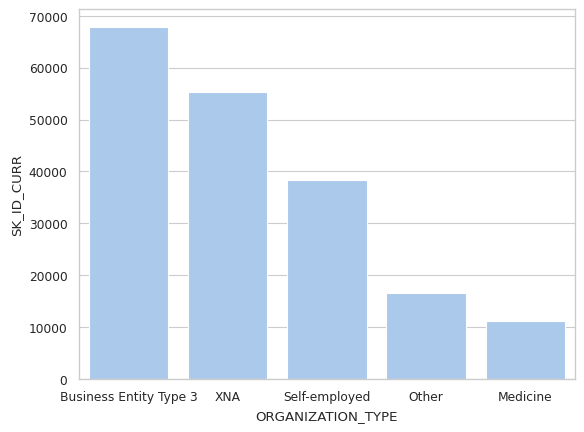

In [57]:
sns.barplot(data=group_organization.sort_values('SK_ID_CURR', ascending=False).head(5), x='ORGANIZATION_TYPE', y='SK_ID_CURR')
plt.show()

In [58]:
# payment ability
organization_ability = organization.groupby(['ORGANIZATION_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
organization_ability.sort_values('SK_ID_CURR', ascending=False).head(5)

,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
10,Business Entity Type 3,No Payment Difficulities,61572
114,XNA,No Payment Difficulities,52369
84,Self-employed,No Payment Difficulities,34442
66,Other,No Payment Difficulities,15357
60,Medicine,No Payment Difficulities,10441


**Conclusion:**
- Business Entity Type 3 is the highest organization that did a loan.
- Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

# General Conclusion From EDA
After conducting EDA, the questions posed have been answered as follows:
1. There were many clients who had not payment difficulties than they who did.
2. The highest average for family status is married with 623512.6 and the last is widow with 480251.0.
3. Client who live in appartment, had the highest average of amount credit loan.
4. The highest client's amount was working type. But, they had no payment difficulities.
5. Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

# Feature Engineering

Here, we would like to train some of machine learning models. The model that we use are: Logistic Regression, Decision Tree Classifier, and Random Forest Classifier.

Before we train our model, there are several things to do:
- Split the data into train set and test set.
- Handling the imbalanced class.
- One-hot encode and label encode for handling categorical data.
- Scaling the numerical data

In [59]:
# deleting unimportant columns
df_final = app_credit.drop(['SK_ID_CURR'], axis=1)
df_final.shape

(306982, 44)

## Adding Information (columns)

In this section, we are going add some columns based on our knowledge about the data.

As we know, in our dataset there is date columns. So, we are going to add how many years they spend their life in some of areas like working and how long they applied for a loan.

In [60]:
df_final.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'D

In [61]:
# adding information
df_final['AGE'] = round(df_final['DAYS_BIRTH'] / 365)
df_final['YEAR_EMPLOYED'] = round(df_final['DAYS_EMPLOYED'] / 365)

## Split The Dataset

In [62]:
X = df_final.drop(['TARGET'], axis=1)
y = df_final['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(230236, 45)
(76746, 45)
(230236,)
(76746,)


## Taking Care of Numerical and Categroical Data

In [63]:
# copy data to label and one hot encode
X_train_labeled = X_train.copy()
X_test_labeled = X_test.copy()

# take the object and numeric columns
object_columns = [col for col in X_train.select_dtypes(include=["object"]) if X_train[col].nunique()==2] # for label encoding
object_columns2 = [col for col in X_train.select_dtypes(include=["object"]) if X_train[col].nunique()>2] # for one hot encoding
# becaue numeric columns also has binary class, we don't need to scale it
numeric_columns = [col for col in X_train.select_dtypes(exclude=["object"]) if X_train[col].nunique()==2] # not for scaling
numeric_columns2 = [col for col in X_train.select_dtypes(exclude=["object"]) if X_train[col].nunique()>2] # for scaling encoding


# ordinal encode for categorical data (2 values)
ordinal_encode = OrdinalEncoder()
X_train_labeled[object_columns+object_columns2] = ordinal_encode.fit_transform(X_train[object_columns+object_columns2])
X_test_labeled[object_columns+object_columns2] = ordinal_encode.transform(X_test[object_columns+object_columns2])

# one hot encoding
# this is for regression model
data_ohe = pd.get_dummies(df_final, drop_first=True)

X_ohe = data_ohe.drop('TARGET', axis=1)
y_ohe = data_ohe['TARGET']

X_train_ohe, X_test_ohe, y_ohe_train, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=42)

# scalling the numerical data
# label data
scaler = StandardScaler()
scaler.fit(X_train_labeled[numeric_columns2+object_columns2])
X_train_labeled[numeric_columns2+object_columns2] = scaler.transform(X_train_labeled[numeric_columns2+object_columns2])
X_test_labeled[numeric_columns2+object_columns2] = scaler.transform(X_test_labeled[numeric_columns2+object_columns2])

# ohe data
scaler_ohe = StandardScaler()
scaler_ohe.fit(X_train_ohe[numeric_columns2])
X_train_ohe[numeric_columns2] = scaler_ohe.transform(X_train_ohe[numeric_columns2])
X_test_ohe[numeric_columns2] = scaler_ohe.transform(X_test_ohe[numeric_columns2])

In [64]:
print(X_train_labeled.shape)
print(X_train_ohe.shape)

(230236, 45)
(230236, 128)


## Handling Imbalanced Data

### Using Upsampling Technique

0    0.919613
1    0.080387
Name: TARGET, dtype: float64


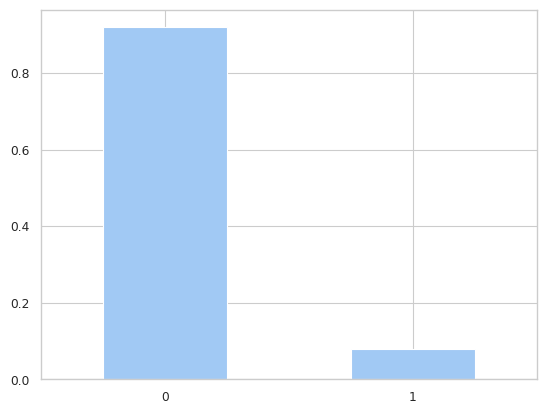

In [65]:
print(y_train.value_counts(normalize=True))
y_train.value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [66]:
# upsampling function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [84]:
# upsample for ordinal dataset
X_train_labeled_upsample, y_train_upsample = upsample(X_train_labeled, y_train, 11)

# upsample for one hot dataset
X_train_ohe_upsample, y_train_ohe_upsample = upsample(X_train_ohe, y_ohe_train, 11)

0    0.5098
1    0.4902
Name: TARGET, dtype: float64


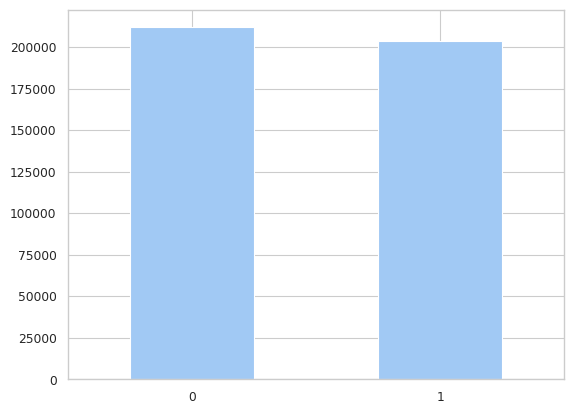

In [85]:
# target after upsample
print(y_train_upsample.value_counts(normalize=True))
y_train_upsample.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

### Using Oversamping Technique

In [76]:
sm = SMOTE()
X_train_labeled_resample, y_train_resample = sm.fit_resample(X_train_labeled, y_train)

sm_ohe = SMOTE()
X_train_ohe_resample, y_train_ohe_resample = sm_ohe.fit_resample(X_train_ohe, y_ohe_train)

0    211728
1    211728
Name: TARGET, dtype: int64


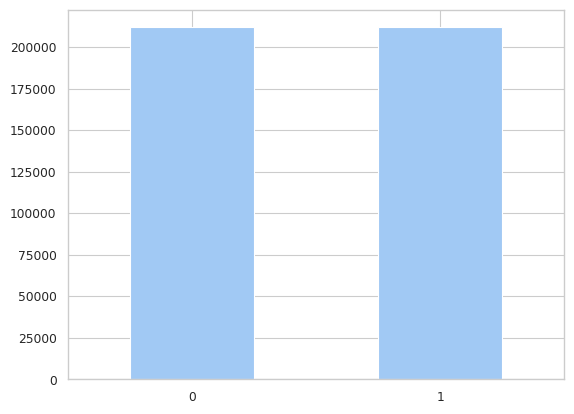

In [77]:
# target after oversampling
print(y_train_ohe_resample.value_counts())
y_train_ohe_resample.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

# Build Machine Learning Model

In [86]:
# function to calculate model evaluation metrics
def print_model_evaluation(y_test, test_predictions, pred_proba):
    print("\033[1m" + 'F1 score: ' + "\033[0m", '{:.3f}'.format(f1_score(y_test, test_predictions)))
    print("\033[1m" + 'Accuracy Score: ' + "\033[0m", '{:.2%}'.format(accuracy_score(y_test, test_predictions)))
    print("\033[1m" + 'Precision: ' + "\033[0m", '{:.3f}'.format(precision_score(y_test, test_predictions)))
    print("\033[1m" + 'Recall: ' + "\033[0m", '{:.3f}'.format(recall_score(y_test, test_predictions)))
    print("\033[1m" + 'Balanced Accuracy Score: ' + "\033[0m", '{:.2%}'.format(balanced_accuracy_score(y_test, test_predictions)))
    print("\033[1m" + 'AUC-ROC Score: ' + "\033[0m", '{:.2%}'.format(roc_auc_score(y_test, pred_proba)))
    print()
    print("\033[1m" + 'Confusion Matrix' + "\033[0m")
    print('-'*50)
    print(confusion_matrix(y_test, test_predictions))
    print()
    print("\033[1m" + 'Classification report' + "\033[0m")
    print('-'*50)
    print(classification_report(y_test, test_predictions))
    print()

# function to plot confusion matrix
def plot_confusion_matrix(y, y_predict):
  "this function plots the confusion matrix"
  cm = confusion_matrix(y, y_predict)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['No Payment Difficulities', 'Payment Difficulities']);
  ax.yaxis.set_ticklabels(['No Payment Difficulities', 'Payment Difficulities']);

# function to plot ROC-AUC
def plot_roc_auc(model, x_test, y_test):
  probabilities_predict = model.predict_proba(x_test)
  probabilities_one = probabilities_predict[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)
  plt.figure()
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Kurva ROC')
  plt.show()

## Logistic Regression

### Using Upsampling Data

#### Using Label Data

In [87]:
model_lr = LogisticRegression()
model_lr.fit(X_train_labeled_upsample, y_train_upsample)
model_predict = model_lr.predict(X_test_labeled)
model_pred_proba = model_lr.predict_proba(X_test_labeled)

F1 score:  0.235
Accuracy Score:  67.91%
Precision:  0.146
Recall:  0.606
Balanced Accuracy Score:  64.57%
AUC-ROC Score:  69.86%

Confusion Matrix
--------------------------------------------------
[[48333 22166]
 [ 2462  3785]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     70499
           1       0.15      0.61      0.24      6247

    accuracy                           0.68     76746
   macro avg       0.55      0.65      0.52     76746
weighted avg       0.89      0.68      0.75     76746


None


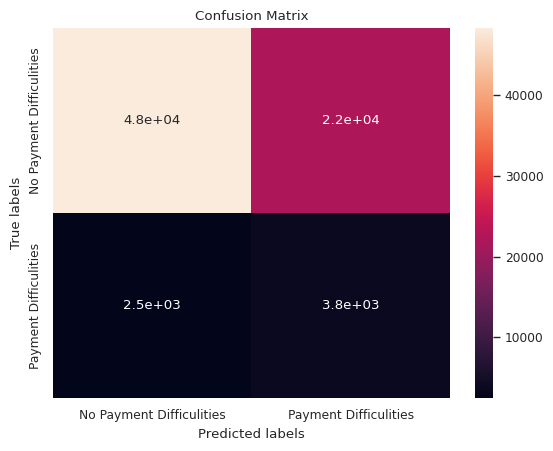

In [88]:
print(print_model_evaluation(y_test, model_predict, model_pred_proba[:,1]))
# plot the confusion matrix
plot_confusion_matrix(y_test, model_predict)

#### Using One Hot Data

In [89]:
model_lr_ohe = LogisticRegression()
model_lr_ohe.fit(X_train_ohe_upsample, y_train_ohe_upsample)
model_predict_ohe = model_lr_ohe.predict(X_test_ohe)
model_predict_proba_ohe = model_lr_ohe.predict_proba(X_test_ohe)

F1 score:  0.235
Accuracy Score:  67.86%
Precision:  0.146
Recall:  0.607
Balanced Accuracy Score:  64.60%
AUC-ROC Score:  70.13%

Confusion Matrix
--------------------------------------------------
[[48286 22213]
 [ 2454  3793]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.68      0.80     70499
           1       0.15      0.61      0.24      6247

    accuracy                           0.68     76746
   macro avg       0.55      0.65      0.52     76746
weighted avg       0.89      0.68      0.75     76746


None


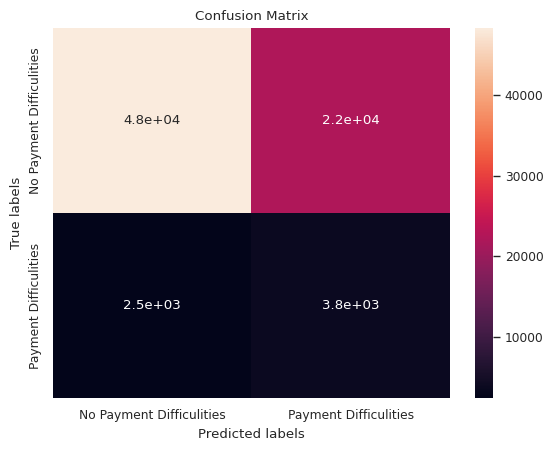

In [90]:
print(print_model_evaluation(y_test_ohe, model_predict_ohe, model_predict_proba_ohe[:,1]))
# plot the confusion matrix
plot_confusion_matrix(y_test_ohe, model_predict_ohe)

### Using Oversampling Data

#### Using Label Data

In [91]:
model_lr_ovr = LogisticRegression()
model_lr_ovr.fit(X_train_labeled_resample, y_train_resample)
model_predict_ovr = model_lr_ovr.predict(X_test_labeled)
model_lr_predict_proba = model_lr_ovr.predict_proba(X_test_labeled)

F1 score:  0.206
Accuracy Score:  66.80%
Precision:  0.128
Recall:  0.528
Balanced Accuracy Score:  60.41%
AUC-ROC Score:  63.86%

Confusion Matrix
--------------------------------------------------
[[47970 22529]
 [ 2950  3297]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     70499
           1       0.13      0.53      0.21      6247

    accuracy                           0.67     76746
   macro avg       0.53      0.60      0.50     76746
weighted avg       0.88      0.67      0.74     76746


None


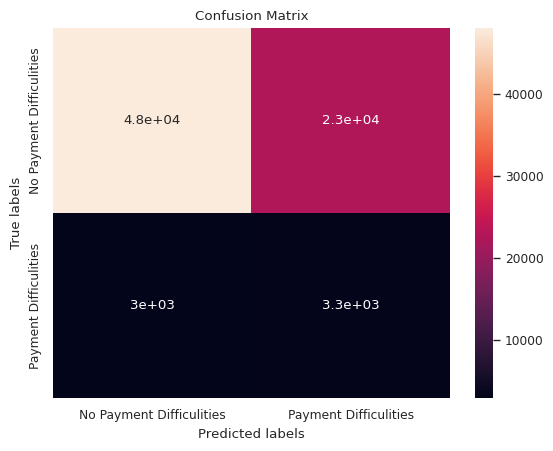

In [92]:
print(print_model_evaluation(y_test, model_predict_ovr, model_lr_predict_proba[:,1]))
# plot the confusion matrix
plot_confusion_matrix(y_test, model_predict_ovr)

#### Using One Hot Data

In [93]:
model_lr_ovr_ohe = LogisticRegression()
model_lr_ovr_ohe.fit(X_train_ohe_resample, y_train_ohe_resample)
model_predict_ovr_ohe = model_lr_ovr_ohe.predict(X_test_ohe)
model_predict_proba_ovr = model_lr_ovr_ohe.predict_proba(X_test_ohe)

F1 score:  0.122
Accuracy Score:  87.72%
Precision:  0.146
Recall:  0.104
Balanced Accuracy Score:  52.50%
AUC-ROC Score:  61.77%

Confusion Matrix
--------------------------------------------------
[[66670  3829]
 [ 5595   652]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     70499
           1       0.15      0.10      0.12      6247

    accuracy                           0.88     76746
   macro avg       0.53      0.53      0.53     76746
weighted avg       0.86      0.88      0.87     76746


None


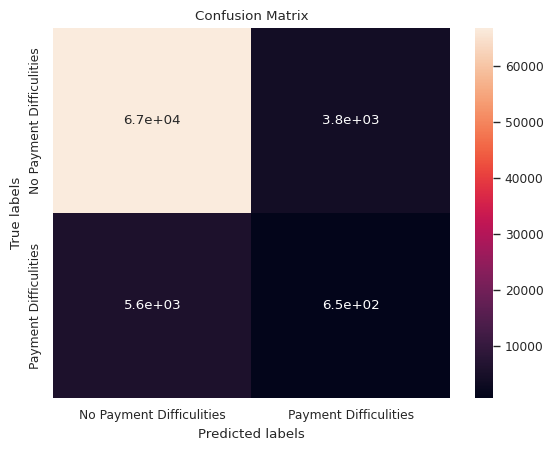

In [94]:
print(print_model_evaluation(y_test_ohe, model_predict_ovr_ohe, model_predict_proba_ovr[:,1]))
# plot the confusion matrix
plot_confusion_matrix(y_test_ohe, model_predict_ovr_ohe)

## Random Forest Classifier

### Using Upsampling Data

#### Using Label Data

In [ ]:
# model evaluation
for depth in range(5, 15):
    rfc = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    rfc_score = cross_val_score(rfc, X_train_labeled_upsample, y_train_upsample, scoring='roc_auc', cv=5)
    print("Max Depth:", depth, "Score:", rfc_score.mean())

Max Depth: 5 Score: 0.6928621665855784
Max Depth: 6 Score: 0.7016783421399975
Max Depth: 7 Score: 0.7122669422022965
Max Depth: 8 Score: 0.7251648866830429
Max Depth: 9 Score: 0.7424522035738333
Max Depth: 10 Score: 0.7657200010049371
Max Depth: 11 Score: 0.7947702004610047
Max Depth: 12 Score: 0.8275532045492117
Max Depth: 13 Score: 0.8640879917375262
Max Depth: 14 Score: 0.8989649278274822


In [95]:
model_rf_label_ups = RandomForestClassifier(n_estimators=50, max_depth=14, random_state=42)
model_rf_label_ups.fit(X_train_labeled_upsample, y_train_upsample)
predict_rf_ups = model_rf_label_ups.predict(X_test_labeled)
predict_proba_rf_ups = model_rf_label_ups.predict_proba(X_test_labeled)

F1 score:  0.251
Accuracy Score:  78.39%
Precision:  0.175
Recall:  0.444
Balanced Accuracy Score:  62.91%
AUC-ROC Score:  69.49%

Confusion Matrix
--------------------------------------------------
[[57386 13113]
 [ 3472  2775]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     70499
           1       0.17      0.44      0.25      6247

    accuracy                           0.78     76746
   macro avg       0.56      0.63      0.56     76746
weighted avg       0.88      0.78      0.82     76746


None


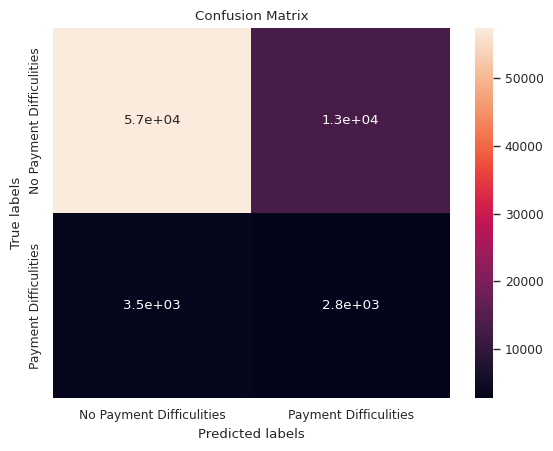

In [97]:
print(print_model_evaluation(y_test, predict_rf_ups, predict_proba_rf_ups[:,1]))
plot_confusion_matrix(y_test, predict_rf_ups)

#### Using One Hot Data

In [ ]:
# model evaluation
for depth in range(5, 15):
    rfc_ohe = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    rfc_score_ohe = cross_val_score(rfc_ohe, X_train_ohe_upsample, y_train_ohe_upsample, scoring='roc_auc', cv=5)
    print("Max Depth:", depth, "Score:", rfc_score_ohe.mean())

Max Depth: 5 Score: 0.6900262732041197
Max Depth: 6 Score: 0.6972519785034362
Max Depth: 7 Score: 0.7070469526840689
Max Depth: 8 Score: 0.7195764463477771
Max Depth: 9 Score: 0.7345988924028025
Max Depth: 10 Score: 0.7538624450510655
Max Depth: 11 Score: 0.7790445155921475
Max Depth: 12 Score: 0.8085929521419084
Max Depth: 13 Score: 0.8397049070744387
Max Depth: 14 Score: 0.8729360132265553


In [98]:
model_rf_ohe_ups = RandomForestClassifier(n_estimators=50, max_depth=14, random_state=42)
model_rf_ohe_ups.fit(X_train_ohe_upsample, y_train_ohe_upsample)
predict_rf_ohe_ups = model_rf_ohe_ups.predict(X_test_ohe)
predict_proba_rf_ohe_ups = model_rf_ohe_ups.predict_proba(X_test_ohe)

F1 score:  0.247
Accuracy Score:  76.41%
Precision:  0.167
Recall:  0.476
Balanced Accuracy Score:  63.27%
AUC-ROC Score:  69.33%

Confusion Matrix
--------------------------------------------------
[[55673 14826]
 [ 3275  2972]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     70499
           1       0.17      0.48      0.25      6247

    accuracy                           0.76     76746
   macro avg       0.56      0.63      0.55     76746
weighted avg       0.88      0.76      0.81     76746


None


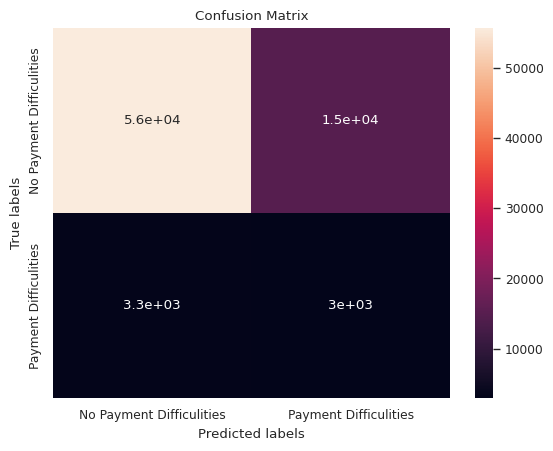

In [99]:
print(print_model_evaluation(y_test_ohe, predict_rf_ohe_ups, predict_proba_rf_ohe_ups[:,1]))
plot_confusion_matrix(y_test_ohe, predict_rf_ohe_ups)

### Using Oversampling Data

#### Using Label Data

In [ ]:
# model evaluation
for depth in range(5, 15):
    rfc_label_resample = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    rfc_score_resample = cross_val_score(rfc_label_resample, X_train_labeled_resample, y_train_resample, scoring='roc_auc', cv=5)
    print("Max Depth:", depth, "Score:", rfc_score_resample.mean())

Max Depth: 5 Score: 0.8741376653912081
Max Depth: 6 Score: 0.8824246974497862
Max Depth: 7 Score: 0.8989509323289697
Max Depth: 8 Score: 0.9087704171665241
Max Depth: 9 Score: 0.919317447897966
Max Depth: 10 Score: 0.9280969594569045
Max Depth: 11 Score: 0.93506969360261
Max Depth: 12 Score: 0.9421042809099228
Max Depth: 13 Score: 0.9471523067305808
Max Depth: 14 Score: 0.9533929951378692


In [100]:
model_rf_label_resample = RandomForestClassifier(n_estimators=50, max_depth=14, random_state=42)
model_rf_label_resample.fit(X_train_labeled_resample, y_train_resample)
predict_rf_label_resample = model_rf_label_resample.predict(X_test_labeled)
predict_proba_rf_label_resample = model_rf_label_resample.predict_proba(X_test_labeled)

F1 score:  0.183
Accuracy Score:  86.04%
Precision:  0.175
Recall:  0.192
Balanced Accuracy Score:  55.59%
AUC-ROC Score:  65.47%

Confusion Matrix
--------------------------------------------------
[[64832  5667]
 [ 5046  1201]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     70499
           1       0.17      0.19      0.18      6247

    accuracy                           0.86     76746
   macro avg       0.55      0.56      0.55     76746
weighted avg       0.87      0.86      0.86     76746


None


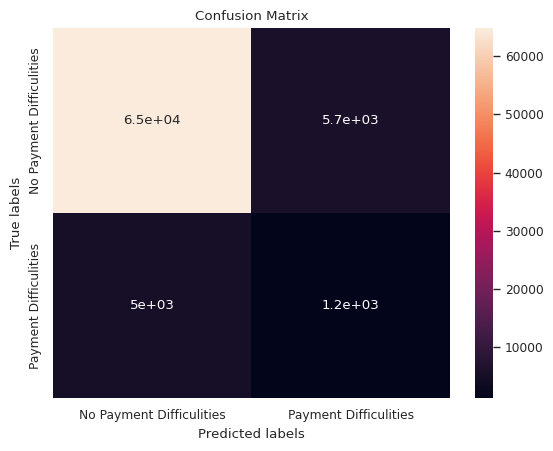

In [101]:
print(print_model_evaluation(y_test, predict_rf_label_resample, predict_proba_rf_label_resample[:,1]))
plot_confusion_matrix(y_test, predict_rf_label_resample)

#### Using One Hot Data

In [ ]:
# model evaluation
for depth in range(5, 15):
    rfc_ohe_resample = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    rfc_score_ohe = cross_val_score(rfc_ohe, X_train_ohe_resample, y_train_ohe_resample, scoring='roc_auc', cv=5)
    print("Max Depth:", depth, "Score:", rfc_score_ohe.mean())

Max Depth: 5 Score: 0.9309876382539427
Max Depth: 6 Score: 0.9309876382539427
Max Depth: 7 Score: 0.9309876382539427
Max Depth: 8 Score: 0.9309876382539427
Max Depth: 9 Score: 0.9309876382539427
Max Depth: 10 Score: 0.9309876382539427
Max Depth: 11 Score: 0.9309876382539427
Max Depth: 12 Score: 0.9309876382539427
Max Depth: 13 Score: 0.9309876382539427
Max Depth: 14 Score: 0.9309876382539427


In [102]:
model_rf_ohe2 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
model_rf_ohe2.fit(X_train_ohe_resample, y_train_ohe_resample)
predict_rf_ohe2 = model_rf_ohe2.predict(X_test_ohe)
predict_proba_rf_ohe2 = model_rf_ohe2.predict_proba(X_test_ohe)

F1 score:  0.210
Accuracy Score:  70.96%
Precision:  0.135
Recall:  0.473
Balanced Accuracy Score:  60.19%
AUC-ROC Score:  64.83%

Confusion Matrix
--------------------------------------------------
[[51504 18995]
 [ 3291  2956]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     70499
           1       0.13      0.47      0.21      6247

    accuracy                           0.71     76746
   macro avg       0.54      0.60      0.52     76746
weighted avg       0.87      0.71      0.77     76746


None


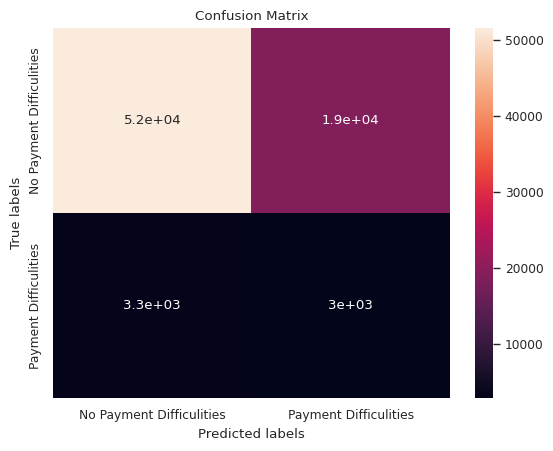

In [103]:
print(print_model_evaluation(y_test_ohe, predict_rf_ohe2, predict_proba_rf_ohe2[:,1]))
plot_confusion_matrix(y_test_ohe, predict_rf_ohe2)

## Model Analysis

So far, we use regression and ensemble model with different kind of datas. The results shows that the data that used label encoding shows better accuracy than one hot encoding.

| Data | Model | ROC-AUC | Accuracy |
| ---- | ----- | ------- | -------- |
| Label Data (Upsampling)  | Logistic Regression | 69.86% | 67.91% |
| One Hot Data (Upsampling)  | Logistic Regression | 70.13% | 67.86% |
| Label Data (Oversampling)| Logistic Regression | 63.86% | 66.80% |
| One Hot Data (Oversampling)| Logistic Regression | 61.77% | 87.72% |
| Label Data (Upsampling)    | Random Forest Classifier | 69.49% | 78.39% |
| One Hot Data (Upsampling)  | Random Forest Classifier | 69.33% | 76.41% |
| Label Data (Oversampling)  | Random Forest Classifier | 65.47% | 86.04% |
| One Hot Data (Oversampling)| Random Forest Classifier | 64.83% | 70.96% |

As we see, the accruacy is high when we use label data. So in the next model, we only use label data (oversampling) to train and test our model.

## LightGBM Classifier

In [104]:
# define hyperparameters to tune
grid_lgbm = {'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators': [50, 100],
             'num_leaves': [10, 20]
            }
# define the model
lgbm_clf = LGBMClassifier(random_state = 42)
# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_clf,
    param_grid = grid_lgbm,
    scoring = "accuracy",
    cv = 5,
    n_jobs = 1
)
# execute search
lgbm_cv = grid_search_lgbm.fit(X_train_labeled_resample, y_train_resample)
# summarize result
print('The best hyperparameters are: {}'.format(lgbm_cv.best_params_))

[LightGBM] [Info] Number of positive: 169382, number of negative: 169382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.877404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8352
[LightGBM] [Info] Number of data points in the train set: 338764, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 169383, number of negative: 169382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8342
[LightGBM] [Info] Number of data points in the train set: 338765, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006

In [106]:
lgbm_model = LGBMClassifier(learning_rate=0.1, n_estimators=100, num_leaves=20)
lgbm_model.fit(X_train_labeled_resample, y_train_resample)
lgbm_model_predict = lgbm_model.predict(X_test_labeled)
lgbm_model_predict_proba = lgbm_model.predict_proba(X_test_labeled)

[LightGBM] [Info] Number of positive: 211728, number of negative: 211728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.866907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8372
[LightGBM] [Info] Number of data points in the train set: 423456, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


F1 score:  0.006
Accuracy Score:  91.85%
Precision:  0.391
Recall:  0.003
Balanced Accuracy Score:  50.12%
AUC-ROC Score:  69.00%

Confusion Matrix
--------------------------------------------------
[[70471    28]
 [ 6229    18]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70499
           1       0.39      0.00      0.01      6247

    accuracy                           0.92     76746
   macro avg       0.66      0.50      0.48     76746
weighted avg       0.88      0.92      0.88     76746


None


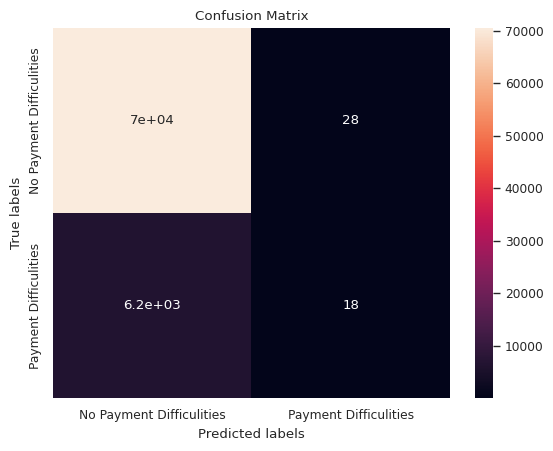

In [107]:
print(print_model_evaluation(y_test, lgbm_model_predict, lgbm_model_predict_proba[:,1]))
plot_confusion_matrix(y_test, lgbm_model_predict)

## XGBoost Classifier

In [108]:
# define hyperparameters to tune
grid_xgb = {'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [4, 6],
            'n_estimators': [50, 100]
           }
# define the model
xgb_clf = XGBClassifier(random_state = 42, verbosity = 0)
# define the grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_clf,
    param_grid = grid_xgb,
    scoring = "roc_auc",
    cv = 5,
    n_jobs = 1
)
# execute search
xgb_cv = grid_search_xgb.fit(X_train_labeled_resample, y_train_resample)
# summarize result
print('The best hyperparameters are: {}'.format(xgb_cv.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [109]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100)
xgb_model.fit(X_train_labeled_resample, y_train_resample)
xgb_pred = xgb_model.predict(X_test_labeled)
xgb_pred_proba = xgb_model.predict_proba(X_test_labeled)

F1 score:  0.020
Accuracy Score:  91.79%
Precision:  0.352
Recall:  0.010
Balanced Accuracy Score:  50.42%
AUC-ROC Score:  67.39%

Confusion Matrix
--------------------------------------------------
[[70383   116]
 [ 6184    63]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70499
           1       0.35      0.01      0.02      6247

    accuracy                           0.92     76746
   macro avg       0.64      0.50      0.49     76746
weighted avg       0.87      0.92      0.88     76746


None


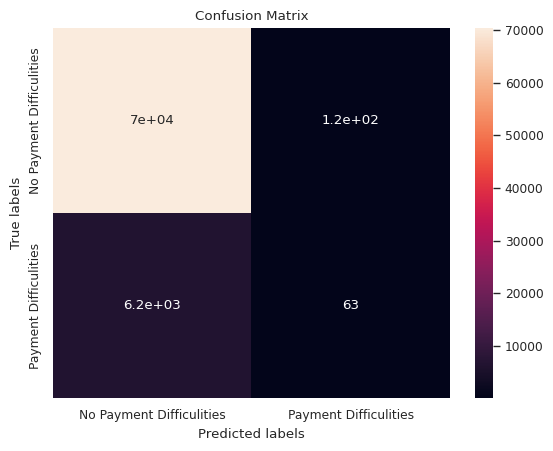

In [112]:
print(print_model_evaluation(y_test, xgb_pred, xgb_pred_proba[:,1]))
plot_confusion_matrix(y_test, xgb_pred)

# Model Evaluation

In [185]:
model_result = {'Model':['Logistic Regression', 'Random Forest Classifier', \
                         'LightGBM Classifier', 'XGBoost Classifier'],
                'AUC-ROC':[roc_auc_score(y_test, model_lr_predict_proba[:,1]), \
                           roc_auc_score(y_test, predict_proba_rf_label_resample[:,1]), \
                           roc_auc_score(y_test, lgbm_model_predict_proba[:,1]), \
                           roc_auc_score(y_test, xgb_pred_proba[:,1])],
                'Accuracy':[accuracy_score(y_test, model_predict_ovr), \
                            accuracy_score(y_test, predict_rf_label_resample), \
                            accuracy_score(y_test, lgbm_model_predict), \
                            accuracy_score(y_test, xgb_pred)]}
model_rslt = pd.DataFrame(model_result, index=model_result['Model'])

                           AUC-ROC  Accuracy
Logistic Regression       0.638566  0.668009
Random Forest Classifier  0.654653  0.860410
LightGBM Classifier       0.689968  0.918471
XGBoost Classifier        0.673890  0.917911



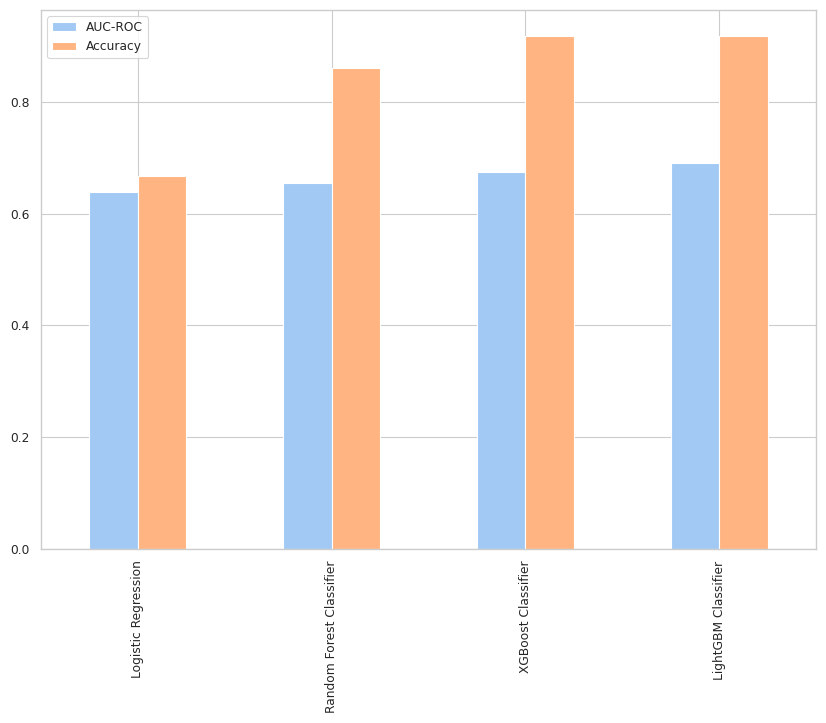

In [186]:
print(model_rslt.drop('Model', axis=1))
print()
model_rslt[['AUC-ROC', 'Accuracy']].sort_values(by='Accuracy').plot(figsize=(10,7), kind='bar');

# Conclusion

We tuned, trained and made predictions using 4 models. With LGBM we got 91% accuracy.

A summary of models, their respective AUC-ROC and accuracy score. AUC-ROC score shows not that good because the data is mostly filled by 0 class. But the accuracy is pretty high arounf 91%. So, for the testing we use LightGBM classifier.

# Overall Conclusion

We looked into the general information about the dataset. We checked for missing values and duplicates. We observed that there are missing values. We drop some columns with large missing values and fill the missing values with median and mode. We carried out EDA and found on that:

* There were many clients who had not payment difficulties than they who did.
* The highest average for family status is married with 623512.6 and the last is widow with 480251.0.
* Client who live in appartment, had the highest average of amount credit loan.
* The highest client's amount was working type. But, they had no payment difficulities.
* Based on how many clients in every top 5 organizations, there was no one of them had payment difficulities.

Based on the observation, the action should we take is:

People living in apartments are given many loans. And most of them are working people who have the largest number of people taking out loans but they don't have payment difficulties. So you could consider creating more campaigns so that working people are more interested.

We split the data into 75% training and 25% testing sets. We used AUC-ROC as our primary metric and accuracy as the secondary metric to predict clients with no payment difficulities. We apply encoding different kind of encoding based on the algorithm to be used. We scale the data by applying standard scaler function to the features. we check class imbalance and used upsampling technique to remove imbalance in the data. We trained different model and applied hyperparameter tuning to tune different models. We choose the best model based on AUC-ROC metric score. The best model is LightGBM Classifier with accuracy 91% but the problem is AUC-ROC because the 0 class is too large.

# Save and Test The Saved Model

## Scenarion 1: Only save the model

In [187]:
import joblib

In [188]:
joblib.dump(lgbm_model, '/content/drive/MyDrive/Model/lgbm_model.joblib')

['/content/drive/MyDrive/Model/lgbm_model.joblib']

## Scenario 2: Save The Model and Feature Eng.

In [206]:
imputation = {}
for columns in app_credit.columns:
  try:
    median = app_credit[columns].median()
    app_credit[columns] = app_credit[columns].fillna(median)
    imputation[columns] = median
  except:
    mode = app_credit[columns].mode()[0]
    app_credit[columns] = app_credit[columns].fillna(mode)
    imputation[columns] = mode

In [201]:
feature_columns = list(X.columns)

In [202]:
age_year = df_final[['AGE', 'YEAR_EMPLOYED']]

In [230]:
save_file = {
    'imputation':imputation,
    'feature_columns':feature_columns,
    'model': lgbm_model
}

In [231]:
joblib.dump(save_file, '/content/drive/MyDrive/Model/model_loan_prediction.joblib')

['/content/drive/MyDrive/Model/model_loan_prediction.joblib']

## Create Prediction Service

In [254]:
# load the model
path_model = '/content/drive/MyDrive/Model/model_loan_prediction.joblib'
save_file = joblib.load(path_model)
save_file['model']

LGBMClassifier(num_leaves=20)

In [255]:
# load the dataset
path = '/content/drive/MyDrive/home-credit-default-risk/application_test.csv'
input = pd.read_csv(path)
data = input.copy()

In [256]:
# labeling data
label_encoding = OrdinalEncoder()
obj_cols = [col for col in input.select_dtypes(include='object')]
input[obj_cols] = label_encoding.fit_transform(input[obj_cols])

In [257]:
# make negative values to be positive values
neg_col = [col for col in input.columns if input[col].dtype not in ['object'] and input[col].min()<0]
input[neg_col] = input[neg_col].abs()
# adding columns
input['AGE'] = round(input['DAYS_BIRTH'] / 365)
input['YEAR_EMPLOYED'] = round(input['DAYS_EMPLOYED'] / 365)

In [258]:
# taking the same column
same_columns = save_file['feature_columns']
input = input[same_columns]

In [238]:
input.isna().sum()

NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
CNT_CHILDREN                     0
AMT_INCOME_TOTAL                 0
AMT_CREDIT                       0
AMT_ANNUITY                     24
AMT_GOODS_PRICE                  0
NAME_TYPE_SUITE                911
NAME_INCOME_TYPE                 0
NAME_EDUCATION_TYPE              0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
REGION_POPULATION_RELATIVE       0
DAYS_BIRTH                       0
DAYS_EMPLOYED                    0
DAYS_REGISTRATION                0
DAYS_ID_PUBLISH                  0
FLAG_MOBIL                       0
FLAG_EMP_PHONE                   0
FLAG_WORK_PHONE                  0
FLAG_CONT_MOBILE                 0
FLAG_PHONE                       0
FLAG_EMAIL                       0
CNT_FAM_MEMBERS                  0
REGION_RATING_CLIENT             0
REGION_RATING_CLIENT_W_CITY      0
WEEKDAY_APPR_PROCESS

In [259]:
# data imputation
imputation_file = save_file['imputation']
for columns in input.columns:
  if input[columns].isnull()[0]:
    input[columns] = input[columns].fillna(imputation_file[columns])

In [260]:
input = input.T.reindex(save_file['feature_columns']).T.fillna(0)

In [261]:
save_file['model'].predict(input)

array([0, 1, 1, ..., 0, 1, 0])

## Create Prediction Function

In [249]:
def predic_loan(input, save_path):
  save_file = joblib.load(save_path)

  # labeling data
  label_encoding = OrdinalEncoder()
  obj_cols = [col for col in input.select_dtypes(include='object')]
  input[obj_cols] = label_encoding.fit_transform(input[obj_cols])

  # make negative values to be positive values
  neg_col = [col for col in input.columns if input[col].dtype not in ['object'] and input[col].min()<0]
  input[neg_col] = input[neg_col].abs()
  # adding columns
  input['AGE'] = round(input['DAYS_BIRTH'] / 365)
  input['YEAR_EMPLOYED'] = round(input['DAYS_EMPLOYED'] / 365)

  # taking the same column
  same_columns = save_file['feature_columns']
  input = input[same_columns]

  # data imputation
  imputation_file = save_file['imputation']
  for columns in input.columns:
    if input[columns].isnull()[0]:
      input[columns] = input[columns].fillna(imputation_file[columns])

  # Transform the shape into training format
  input = input.T.reindex(save_file['feature_columns']).T.fillna(0)

  # model prediction
  predict = save_file['model'].predict(input)

  return predict

In [250]:
# test function
predic_loan(input, path_model)

array([0, 1, 1, ..., 0, 1, 0])

In [262]:
predict = pd.Series(predic_loan(input, path_model), name='TARGET').astype('int32')
results = pd.concat([data['SK_ID_CURR'], predict], axis=1)
results.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,1
3,100028,0
4,100038,1


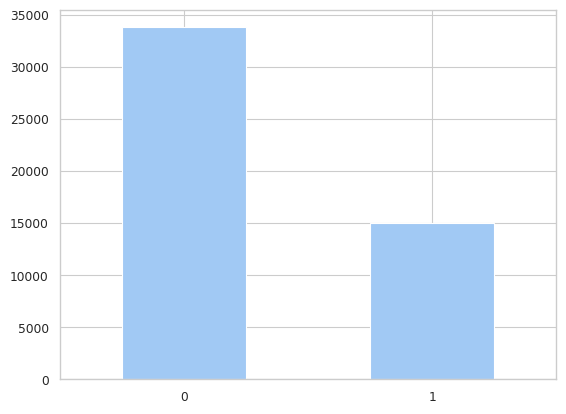

In [266]:
# distribution results
results['TARGET'].value_counts().plot(kind='bar')
plt.xticks(rotation=0);